In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import shift
from numpy import prod
import pandas as pd
from matplotlib.pyplot import figure

In [2]:
import warnings
warnings.filterwarnings("ignore")

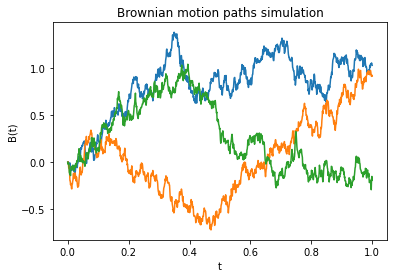

In [10]:
## BM simulation
N = 1000
BM = np.empty((N,3))
t = np.linspace(0,1,N)
for i in range(3):
    inc= np.sqrt(1/N)*np.random.normal(0,1,N-1)
    cumsum=np.cumsum(inc).tolist()
    b=[0] + cumsum
    BM[:,i] = np.array(b)
    plt.plot(t,b)
plt.title("Brownian motion paths simulation")
plt.xlabel("t")
plt.ylabel("B(t)")
plt.savefig("BM_paths")

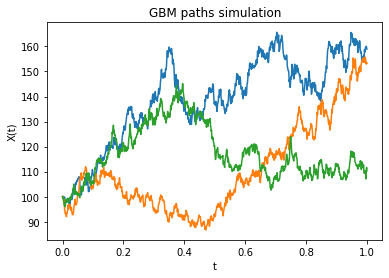

In [11]:
##GBM simulation
N = 1000
mu=0.2
sigma=0.3
t = np.linspace(0,1,N)
for i in range(3):
    s = [100]
    for j in range(N-1):
        s.append(s[j] + s[j]*mu*(1/N) + s[j]*sigma*(BM[j+1][i]-BM[j][i]))
    plt.plot(t,s) 
plt.title("GBM paths simulation") 
plt.xlabel("t")
plt.ylabel("X(t)")
plt.savefig("GBM_paths.png")

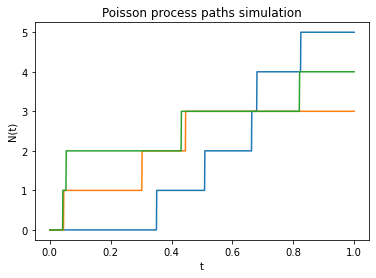

In [12]:
## Poisson process generation for simulation purpose
lamda = 5
N=1000
t = np.linspace(0,1,N)
Nt = np.empty((N,3))
nt_inc = np.empty((N-1,3))
for i in range(3):
    nt_inc[:,i]=np.random.poisson(lam=lamda*(1/N),size=N-1)
    nt  = np.cumsum(nt_inc[:,i]).tolist()
    nt = [0] + nt
    Nt[:,i] = nt
plt.plot(t,Nt)    
plt.title("Poisson process paths simulation")
plt.xlabel("t")
plt.ylabel("N(t)")
plt.savefig("Poisson_simulation.png")    

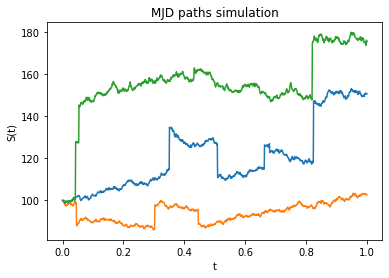

In [13]:
## MJD paths simulations
for i in range(3):
    sigma=0.1#diffusion voltatily
    mu=0.01#diffusion mean
    m=0 #jump mean
    delta=0.1#jump std dev
    s0=100
    diffusion=np.array([(mu - 0.5*sigma**2)*(1/N) + sigma*(BM[j+1,i]-BM[j,i]) for j in range(N-1)])
    jump =[]
    for k in nt_inc[:,i]:
        if k == 1:
            jump.append(np.random.normal(m,delta))
        else: jump.append(0) 
    jump = np.array(jump)
    r = diffusion + jump
    s = np.exp(r).tolist()
    mjd_st=[s0]
    for i in range(N-1):
        mjd_st.append(mjd_st[i]*s[i])
    plt.plot(t,mjd_st)
    plt.xlabel('t') 
    plt.ylabel('S(t)')
    plt.title('MJD paths simulation')
plt.savefig('MJD_simulation.png')

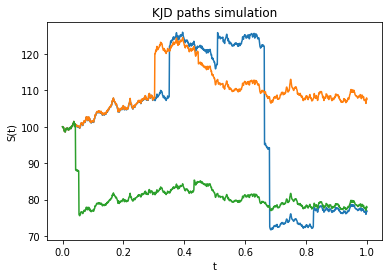

In [14]:
    ## KJD paths simulation
    for i in range(3):
        p = 0.5
        n_1 = 10
        n_2 = 10
        kou_jumps = []
        for k in nt_inc[:,i]:
            if k == 1:
                if np.random.binomial(1,p) == 1:
                    kou_jumps.append(np.random.exponential(scale=1/n_1))
                else : kou_jumps.append(-np.random.exponential(scale=1/n_2))
            else: kou_jumps.append(0)
        kou_jumps = np.array(kou_jumps)
        kou_r = diffusion + kou_jumps
        kou_s = np.exp(kou_r).tolist()
        kou_st=[s0]
        for i in range(N-1):
            kou_st.append(kou_st[i]*kou_s[i])
    #plt.subplot(3, 1, 3)
        plt.plot(t,kou_st)
        plt.xlabel('t') 
        plt.ylabel('S(t)')
        plt.title('KJD paths simulation')
plt.savefig('KJD_simulation.png')        

In [369]:
def returns(data): ## compute daily simple returns
    N=len(data)
    r=np.array((N,))
    r = (data/data.shift(1))-1
    #r = np.log(data) - np.log(data.shift(1))
    #r = r.dropna()
    r = r[1:N]
    return r

[*********************100%***********************]  1 of 1 completed


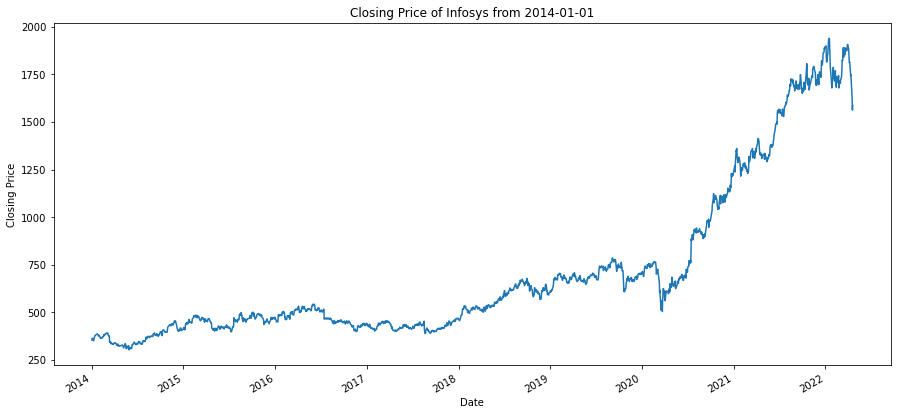

In [486]:
import yfinance as yf
data = yf.download('INFY.NS',start="2014-01-01",end="2022-04-21") ##Infosys 8 years historical data
data['Adj Close'].plot(figsize = (15,7))
price = data['Adj Close']
plt.title("Closing Price of Infosys from 2014-01-01")
plt.ylabel('Closing Price')
plt.savefig('INFY_closing prices.png')

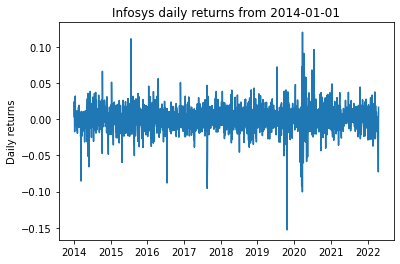

In [487]:
returns_data = returns(price)
plt.plot(data.index[1:],returns_data)
plt.title("Infosys daily returns from 2014-01-01")
plt.ylabel("Daily returns")
plt.savefig('INFY_daily_returns')

In [426]:
## Infosys statistics
from scipy.stats import kurtosis,skew
print(np.mean(returns_data))
print(np.std(returns_data))
print(skew(returns_data))
print(kurtosis(returns_data,fisher=False))
print(np.std(returns_data)*(252)**0.5)

0.0008806103640999614
0.017081204978666272
-0.29952398794247376
11.922975145640473
0.2711557228012158


In [427]:
BS_call(S0=1615.70,K=1800,T=35,r=0.045,sigma=np.std(returns_data)*(252)**0.5)

7.45217

In [428]:
N = len(returns_data)
jumps =0
dt = 1/252
diffusion_component = []
for i in range(N): ## computing jumps
    if np.abs(returns_data[i]) >= 3*np.std(returns_data):
        jumps= jumps + 1
    else : diffusion_component.append(returns_data[i])
## initialisng parameters for MLE purpose        
initial_sigma = np.std(diffusion_component)*(1/dt)**0.5
initial_mu = (np.mean(diffusion_component) + (0.5*(initial_sigma)**2)*dt)/dt
initial_lamda = jumps*252/len(returns_data)
print(jumps)
print(3*np.std(returns_data))
print(initial_mu)
print(initial_sigma)
print(initial_lamda)

28
0.05124361493599881
0.27387742981476104
0.22715479083535642
3.452054794520548


In [429]:
from scipy.stats import norm
def mjd_neg_log_likelihood(para,returns): ## computes mjd neg of log_likelihood
    x=returns
    N = len(x)
    dt = 1/252      
    mu,sigma,m,delta,lam = para
    likelihood = [] 
    for i in range(N):
        likelihood.append(lam*dt*norm.pdf(x[i],mu*dt + m,((sigma**2)*dt + delta**2)**0.5) + (1- lam*dt)*norm.pdf(x[i],mu*dt,((sigma**2)*dt)**0.5))   
    l = sum(np.log(likelihood))
    return(-l)  ## returns negative of log-likelihood

In [430]:
from scipy.optimize import minimize ## mjd_log-likelihood optimisation for estimating parameters
bounds = ((-np.inf,np.inf),(0,np.inf),(-np.inf,np.inf),(0,np.inf),(0,np.inf)) ## bounds for estimating the parameters
mjd_res = minimize(mjd_neg_log_likelihood, (initial_mu,initial_sigma,0.5,0.5,initial_lamda),args = returns_data, method='SLSQP',bounds=bounds,options={'disp': True} )
print(mjd_res)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -5629.3295321770765
            Iterations: 46
            Function evaluations: 324
            Gradient evaluations: 43
     fun: -5629.3295321770765
     jac: array([-0.00311279, -0.003479  ,  0.01086426, -0.05438232,  0.00024414])
 message: 'Optimization terminated successfully'
    nfev: 324
     nit: 46
    njev: 43
  status: 0
 success: True
       x: array([ 2.53644454e-01,  2.05033499e-01, -1.70289222e-03,  4.10802230e-02,
        1.86283685e+01])


In [431]:
## MJD estimated parameters
print("MJD_parameters - mu = {},sigma = {},jump_mean = {},jump_std = {},lamda = {}".format(mjd_res.x[0],mjd_res.x[1],mjd_res.x[2],mjd_res.x[3],mjd_res.x[4]))

MJD_parameters - mu = 0.2536444541179488,sigma = 0.20503349885386263,jump_mean = -0.0017028922239390037,jump_std = 0.04108022296460471,lamda = 18.62836845809842


Kou Model

In [432]:
from scipy.stats import norm
def kou_neg_log_likelihood(para,returns): ## Kou neg of log_likelihood for MLE purpose
    x = returns
    N = len(x)
    dt = 1/252
    mu,sigma,lam,p,n_1,n_2 = para
    q = 1-p
    likelihood = []  
    for i in range(N):
        likelihood.append(((1-lam*dt)*norm.pdf(((x[i]-mu*dt)/(sigma*(dt)**0.5)),0,1))/(sigma*(dt)**0.5) + lam*dt*(p*n_1*np.e**((((sigma*n_1)**2)*dt*0.5) - (((x[i]-mu*dt)*n_1)))*norm.cdf(((x[i]-mu*dt-n_1*dt*(sigma)**2)/(sigma*(dt)**0.5))) + q*n_2*np.e**((((sigma*n_2)**2)*dt*0.5) + ((x[i]-mu*dt)*n_2))*norm.cdf((-(x[i]-mu*dt+n_2*dt*(sigma)**2)/(sigma*(dt)**0.5))))) 
    l = sum(np.log(likelihood))
    return(-l) ## returns negative of log-likelihood

In [433]:
from scipy.optimize import minimize ## kou_log-likelihood optimisation for estimating parameters
bounds = ((-np.inf,np.inf),(0,np.inf),(0,np.inf),(0,1),(1,np.inf),(0,np.inf)) ## bounds for estimating the parameters
kou_res = minimize(kou_neg_log_likelihood, (initial_mu,initial_sigma,initial_lamda,0.5,2,2),args = returns_data,bounds=bounds, method='SLSQP',options={'disp': True} )
print(kou_res)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -5633.378667826034
            Iterations: 23
            Function evaluations: 181
            Gradient evaluations: 23
     fun: -5633.378667826034
     jac: array([-0.04577637,  1.41644287,  0.00317383, -0.02398682, -0.00299072,
        0.00372314])
 message: 'Optimization terminated successfully'
    nfev: 181
     nit: 23
    njev: 23
  status: 0
 success: True
       x: array([ 0.10661389,  0.19047708, 49.74132372,  0.63030669, 59.43432793,
       44.68740264])


In [434]:
## Kou estimated parameters
print("KJD_parameters - mu = {},sigma = {},lamda = {},p = {},n_1 = {},n_2 = {}".format(kou_res.x[0],kou_res.x[1],kou_res.x[2],kou_res.x[3],kou_res.x[4],kou_res.x[5]))

KJD_parameters - mu = 0.10661389312636697,sigma = 0.1904770810252137,lamda = 49.74132371761107,p = 0.6303066929441188,n_1 = 59.43432793135078,n_2 = 44.68740263546749


BS Model

In [435]:
## BS parameters estimation
dt = 1/252
bs_sigma = np.std(returns_data)/(dt)**0.5
bs_mu = (np.mean(returns_data) + 0.5*((bs_sigma)**2)*dt)/dt

In [436]:
print("BS_parameters - mu ={}, sigma ={}".format(bs_mu,bs_sigma))

BS_parameters - mu =0.2586765247571152, sigma =0.2711557228012158


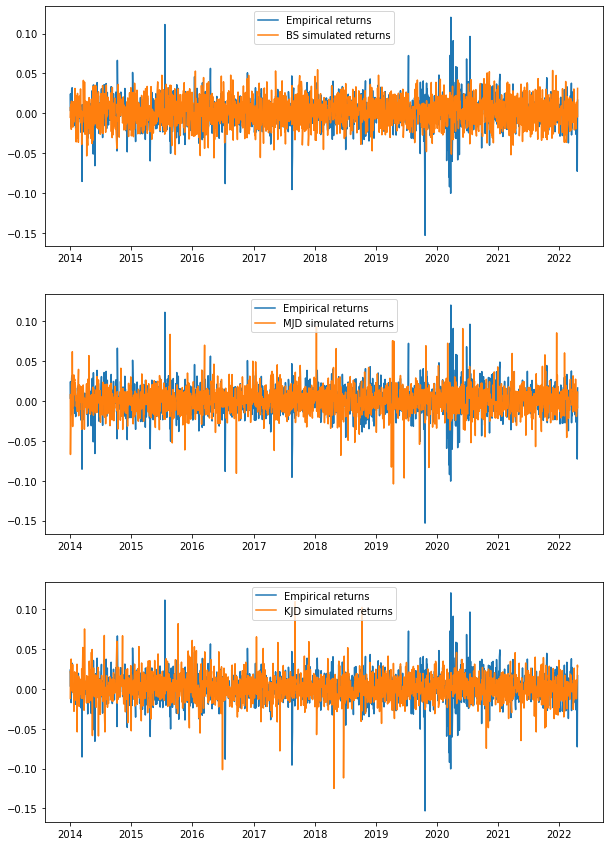

In [472]:
## Simulating BS,MJD and KJD returns through estimated parameters for comparison with empirical density of returns
N = len(returns_data)
bs_sim_returns = np.random.normal(np.mean(returns_data),np.std(returns_data),N).tolist() ## BS_model simulated returns
mjd_sim_returns = []
kou_sim_returns = []
dt =1/252
mjd_mu,mjd_sigma,mjd_m,mjd_delta,mjd_lamda = mjd_res.x
kou_mu,kou_sigma,kou_lamda,p,n_1,n_2 = kou_res.x
for i in range(N):
    if np.random.binomial(1,mjd_lamda*dt) == 1: ## if there is jump for MJD_model
        mjd_sim_returns.append(mjd_mu*dt + mjd_sigma*((dt)**0.5)*np.random.normal(0,1) + np.random.normal(mjd_m,mjd_delta))
    else: mjd_sim_returns.append(mjd_mu*dt + mjd_sigma*((dt)**0.5)*np.random.normal(0,1)) ## if there is no jump for MJD_model
        
    if np.random.binomial(1,kou_lamda*dt) == 1:## if there is jump for Kou_model
        if np.random.binomial(1,p) == 1: ## positive jump for Kou_model
            kou_sim_returns.append(kou_mu*dt + kou_sigma*((dt)**0.5)*np.random.normal(0,1) + np.random.exponential(scale=1/n_1))
        ## negative jump for Kou_model
        else: kou_sim_returns.append(kou_mu*dt + kou_sigma*((dt)**0.5)*np.random.normal(0,1) - np.random.exponential(scale=1/n_2))
    
    else :  kou_sim_returns.append(kou_mu*dt + kou_sigma*((dt)**0.5)*np.random.normal(0,1))  ## if there is no jump for Kou_model       
figure(figsize=(10, 15))            
plt.subplot(3,1,1)
plt.plot(data.index[1:],returns_data)
plt.plot(data.index[1:],bs_sim_returns)
plt.legend(['Empirical returns','BS simulated returns'],loc='upper center')
plt.subplot(3,1,2)
plt.plot(data.index[1:],returns_data)
plt.plot(data.index[1:],mjd_sim_returns)
plt.legend(['Empirical returns','MJD simulated returns'],loc='upper center')
plt.subplot(3,1,3)
plt.plot(data.index[1:],returns_data)
plt.plot(data.index[1:],kou_sim_returns)
plt.legend(['Empirical returns','KJD simulated returns'],loc='upper center')
plt.savefig('simulated_returns.png')

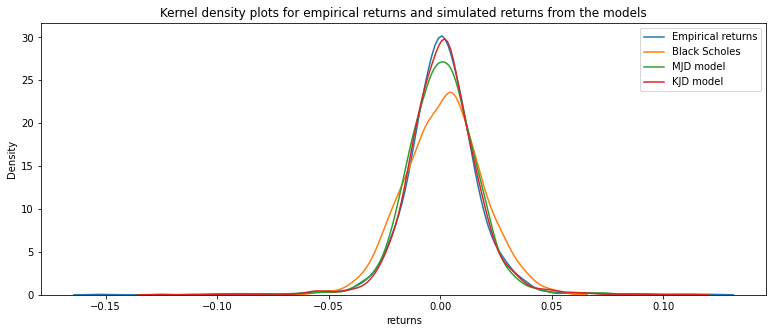

In [473]:
## Density plots
import seaborn as sns
figure(figsize=(13, 5))
sns.kdeplot(returns_data)
sns.kdeplot(bs_sim_returns)
sns.kdeplot(mjd_sim_returns)
sns.kdeplot(kou_sim_returns)
plt.xlabel('returns')
plt.legend(['Empirical returns','Black Scholes','MJD model','KJD model'])
plt.title('Kernel density plots for empirical returns and simulated returns from the models')
plt.savefig('KDE_plot_INFY.png')

In [439]:
## MJD Parameters and statistics
mu,sigma,m,delta,lamda = mjd_res.x
dt = 1/252
mjd_mean = (mu )*dt + m*lamda*dt
mjd_variance = (sigma**2)*dt + ((lamda*dt))*(delta**2 + m**2)
mjd_skewness = ((3*delta**2 + m**2)*m*lamda*dt)/mjd_variance**(3/2)
mjd_kurtosis = ((3*(delta)**4 + 6*(m*delta)**2 + (m)**4)*lamda*dt)/(mjd_variance)**2 + 3
#mjd_kurtosis = ((3*(delta)**4 + 6*(m*delta)**2 + (m)**4)*lamda*dt+ (3*(lamda**2)*(m**2 + (delta**2))**2 + 6*lamda*(sigma**2)*(delta**2 + m**2) +3*sigma**4)*(dt)**2)/(mjd_variance)**2
#mjd_kurtosis = (3*(delta)**4 + 6*(m*delta)**2 + (m)**4)*lamda*dt+ (3*((sigma**2 + lamda*(m**2 + delta**2))**(2))*(dt)**2)/(mjd_variance)**2

In [440]:
## Kou Parameters and statistics
mu,sigma,lamda,p,n_1,n_2 = kou_res.x
q =1-p
kou_mean = mu*dt + lamda*((p/n_1)-(q/n_2))*dt
kou_variance = (sigma**2)*dt + (p*q*((1/n_1 + 1/n_2))**2 + (p/(n_1)**2 + q/(n_2)**2 ))*lamda*dt + lamda*dt*(p/n_1 - q/n_2)**2
kou_skewness =  (6*(p/n_1**3 - q/n_2**3))*lamda*dt/(kou_variance)**(3/2)
#kou_kurtosis = (24*(p/(n_1)**4 + q/(n_2)**4)*lamda*dt + (3*(lamda**2)*(p/(n_1)**2 + q/(n_2)**2)**2 + 6*lamda*((sigma)**2)*(p/(n_1)**2 + q/(n_2)**2) + 3*sigma**4)*(dt)**2)/(kou_variance)**(2)
#(((3*sigma**4 + 12*(sigma**2)*lamda*(p/(n_1)**2 + q/(n_2)**2) - 24*(p/n_1 - q/n_2)*(p/(n_1)**3 - q/(n_2)**3)*(lamda)**2 + 24*7*(p/(n_1)**4 + q/(n_2)**4)*(lamda)**2)*(dt)**2) + (24*(p/(n_1)**4 + q/(n_2)**4)*(lamda*dt)))/(kou_variance)**(2)
kou_kurtosis = (24*(p/(n_1)**4 + q/(n_2)**4)*lamda*dt)/(kou_variance)**2 + 3
#kou_kurtosis = (24*(p/(n_1)**4 + q/(n_2)**4) + 5*(p/n_1 - q/n_2)**4 + 12*(p/(n_1)**2 + q/(n_2)**2)*(p/n_1 - q/n_2)**2 -24*(p/(n_1)**2 + q/(n_2)**2)*(p/n_1 - q/n_2) + 6*((p/n_1 - q/n_2)**2)*(p*q*((1/n_1 + 1/n_2))**2 + (p/(n_1)**2 + q/(n_2)**2 )) + (p/n_1 - q/n_2)**4)/(kou_variance)**(2) + 3

In [441]:
## BS statistics
dt = 1/252
bs_mean = (bs_mu - 0.5*(bs_sigma)**2)*dt
bs_std = bs_sigma*(dt)**0.5

In [442]:
from scipy.stats import kurtosis, skew
print("Mean, Variance, skewness and kurtosis in order")
print("bs_model - {},{}".format(bs_mean,bs_std**2)) 
print("stock returns - {},{},{},{}".format(np.mean(returns_data),np.var(returns_data),skew(returns_data),kurtosis(returns_data,fisher = False)))
print("mjd_model- {},{},{},{}".format(mjd_mean,mjd_variance,mjd_skewness,mjd_kurtosis))
print("kou_model- {},{},{},{}".format(kou_mean,kou_variance,kou_skewness,kou_kurtosis))

Mean, Variance, skewness and kurtosis in order
bs_model - 0.0008806103640999615,0.00029176756352321346
stock returns - 0.0008806103640999614,0.00029176756352321346,-0.29952398794247376,11.922975145640473
mjd_model- 0.0008806442473253268,0.0002917845433436392,-0.12793917329590404,10.443762945125606
kou_model- 0.0008834190081203151,0.0002874983350615028,-0.2770893131908882,11.208303987373819


Pricing through Monte Carlo method

In [474]:
## MJD option price calculation
def mjd_price_call(para,r,T,S0,Strike):
    T = T/365
    sigma,m,delta,lamda = para
    k = (np.e**(m + ((delta)**2)*0.5)) - 1
    sim = 100000
    b_T = np.random.normal(0,1,sim)*(T)**0.5
    n_T = np.random.poisson(lam=lamda*(T),size=sim)
    jumps_component = np.array([np.sum(np.random.normal(m, delta,n_T[i])) for i in range(sim)])
    s_T = S0*np.e**((r-0.5*(sigma)**2-lamda*k)*T + sigma*b_T + jumps_component)
    discounted_payoff = []
    for i in range(sim):
        discounted_payoff.append(np.e**((-r)*T)*(max(s_T[i]-Strike,0)))
    return round(np.mean(discounted_payoff),5) 

## Kou model option price calculation
def kou_price_call(para,r,T,S0,Strike):
    T = T/365
    sigma,lamda,p,n_1,n_2 = para
    k= (p*n_1)/(n_1 -1) + (q*n_2)/(n_2 + 1) - 1
    sim = 100000
    b_T = np.random.normal(0,1,sim)*(T)**0.5
    n_T = np.random.poisson(lam=lamda*(T),size=sim)
    jumps = []
    for i in range(sim):
        temp =[] ##list for storing jump points
        for j in range(n_T[i]):
            if np.random.binomial(1,p) == 1:
                temp.append(np.random.exponential(scale=1/n_1))
            else : temp.append(-np.random.exponential(scale=1/n_2))
        jumps.append(sum(temp))
    jumps_component = np.array(jumps)    
    s_T = S0*np.e**((r-0.5*(sigma)**2-lamda*k)*T + sigma*b_T + jumps_component)
    discounted_payoff = []
    for i in range(sim):
        discounted_payoff.append(np.e**((-r)*T)*(max(s_T[i]-Strike,0)))
    return round(np.mean(discounted_payoff),5) 
       

In [475]:
def BS_call(S0,K,T,r,sigma): ## calculate BS call price
    T=T/365
    d1 = (np.log(S0/K) + (r+0.5*(sigma)**2)*T)/(sigma*np.sqrt(T))
    d2 = (np.log(S0/K) + (r-0.5*(sigma)**2)*T)/(sigma*np.sqrt(T))
    call_price = S0*norm.cdf(d1) - (K*np.exp(-r*T)*norm.cdf(d2))
    return round(call_price,5)

In [116]:
BS_call(S0=1623.80,K=1660,T=35,r=0.045,sigma=np.std(returns_data)*(252)**0.5)

42.97759

Pricing Infosys Call options dated 21/04/22, S0 =1615.70 ,expiry-26/05/22

In [476]:
call_data = pd.read_csv('infy21april.csv')
call_data["ASK PRICE"] = [float(str(i).replace(",", "")) for i in call_data["ASK PRICE"]]
call_data["STRIKE PRICE"] = [float(str(i).replace(",", "")) for i in call_data["STRIKE PRICE"]]
call_data

,BID PRICE,ASK PRICE,STRIKE PRICE
0,132.70,135.85,1500.0
1,111.55,121.30,1520.0
2,101.05,103.50,1540.0
3,87.70,88.75,1560.0
4,73.90,75.35,1580.0
5,61.80,62.85,1600.0
6,52.10,52.50,1620.0
7,42.55,43.00,1640.0
8,34.65,35.40,1660.0
9,28.00,28.80,1680.0


In [482]:
df = call_data
K = [df['STRIKE PRICE'][i] for i in range(len(df))]
BS_prices = []
MJD_prices = []
Kou_prices = []
mid_prices = (call_data["ASK PRICE"] + call_data["BID PRICE"])/2
for i in range(len(df)):
    BS_prices.append(BS_call(S0=1615.70,K=K[i],T=35,r=0.045,sigma=np.std(returns_data)*(252)**0.5))
    MJD_prices.append(mjd_price_call(mjd_res.x[1:5],r=0.045,T=35,S0=1615.70,Strike=K[i]))
    Kou_prices.append(kou_price_call(kou_res.x[1:6],r=0.045,T=35,S0=1615.70,Strike=K[i]))
    

In [484]:
Prices = pd.DataFrame({'STRIKE PRICE':K,'BID PRICE':df['BID PRICE'],'ASK PRICE':df['ASK PRICE'],'MID PRICE':mid_prices,
                       'BS PRICE':BS_prices,'MJD PRICE':MJD_prices,'KJD PRICE':Kou_prices})
#Prices = pd.DataFrame({'STRIKE PRICE':K,'BID PRICE':df['BID PRICE'],'ASK PRICE':df['ASK PRICE'],'MID PRICE':mid_prices,'BS PRICE':BS_prices})    
Prices

,STRIKE PRICE,BID PRICE,ASK PRICE,MID PRICE,BS PRICE,MJD PRICE,KJD PRICE
0,1500.0,132.70,135.85,134.275,134.40275,134.89830,134.27881
1,1520.0,111.55,121.30,116.425,118.62497,119.20429,118.17841
2,1540.0,101.05,103.50,102.275,103.79511,102.97129,102.97846
3,1560.0,87.70,88.75,88.225,90.00160,88.99340,90.07431
4,1580.0,73.90,75.35,74.625,77.31336,76.58405,76.77823
5,1600.0,61.80,62.85,62.325,65.77603,65.53064,64.64055
6,1620.0,52.10,52.50,52.300,55.40992,54.75655,54.19889
7,1640.0,42.55,43.00,42.775,46.20955,45.66211,45.45656
8,1660.0,34.65,35.40,35.025,38.14495,37.53703,37.38410
9,1680.0,28.00,28.80,28.400,31.16438,30.70015,30.18425


In [485]:
import base64
import pandas as pd
from IPython.display import HTML

def create_download_link( df, title = "Download CSV file", filename = "data.csv"):
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

df1 = Prices 
create_download_link(df1)